# DCGAN

ガルパンのキャラクタ画像を使ってDCGANをしてみる

In [1]:
import os
from PIL import Image

import numpy as np
import tensorflow as tf

from glob import glob

from helper import get_image, get_batch, images_square_grid
from helper import Dataset

data_dir = './data'

files = glob(os.path.join(data_dir, '**/*.jpg'))
print(len(files))

width = 256
height = 256
image_files = []
for path in files:
    image = Image.open(path)
    if image.size[0] > width and image.size[1] > height:
        image_files.append(path)
        
print(len(image_files))

13007
8285


In [2]:
get_image(image_files[0], width, height, "RGB").shape

(256, 256, 3)

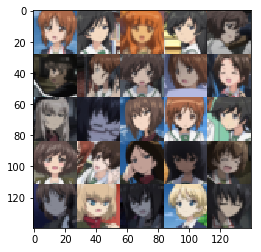

In [3]:
%matplotlib inline
from matplotlib import pyplot
import random

number_of_image = 25
image_size = 28

random.shuffle(image_files)
images = get_batch(image_files[:number_of_image], image_size, image_size, 'RGB')
pyplot.imshow(images_square_grid(images, 'RGB'))
pyplot.show()

## Input

In [4]:
def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    real_dim = (image_width, image_height, image_channels)
    inputs_real = tf.placeholder(tf.float32, (None, *real_dim), name='input_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32, None, name='learning_rate')

    return inputs_real, inputs_z, learning_rate

## Discriminator

In [5]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    alpha = 0.01
    with tf.variable_scope('discriminator', reuse=reuse):
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        # 14x14x64
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        # 7x7x128
        
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        # 4x4x256

        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        return out, logits

## Generator

In [6]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    alpha = 0.01
    with tf.variable_scope('generator', reuse=(is_train == False)):
        x1 = tf.layers.dense(z, 3*3*512)
        
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 3, 3, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        # 3x3x512
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 3, strides=2, padding='valid')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        # 7x7x128
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        # 14x14x64
        
        # Output layer, 28x28x3
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=2, padding='same')
        out = tf.tanh(logits)
        return out

## Loss

In [7]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(
            logits=d_logits_real, labels=tf.ones_like(d_model_real) * 0.9))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(
            logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(
            logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake
    return d_loss, g_loss


## Optimization

In [8]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt



## Neural Network Training

In [9]:
def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

## Train


In [10]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    input_real, input_z, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    d_opt, g_opt = model_opt(d_loss, g_loss, lr, beta1)
    
    steps = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # Change the real image range to between -1 and 1
                normalized = (batch_images - batch_images.min()) / (batch_images.max() - batch_images.min())
                batch_images = 2 * normalized - 1
                
                # TODO: Train Model
                steps += 1
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, input_real: batch_images, lr: learning_rate})
                
                if steps %  20 == 0:
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})
                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                if steps % 100 == 0:
                    show_generator_output(sess, number_of_image, input_z, data_shape[3], data_image_mode)

## Garupan

Epoch 1/24... Discriminator Loss: 0.9970... Generator Loss: 1.3745
Epoch 1/24... Discriminator Loss: 0.9248... Generator Loss: 1.4834
Epoch 1/24... Discriminator Loss: 2.2209... Generator Loss: 2.9480
Epoch 1/24... Discriminator Loss: 1.3390... Generator Loss: 0.9363
Epoch 2/24... Discriminator Loss: 0.9062... Generator Loss: 1.4704


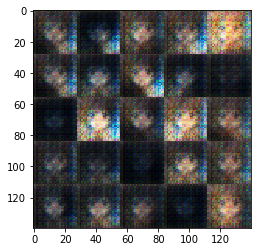

Epoch 2/24... Discriminator Loss: 0.8661... Generator Loss: 2.6208
Epoch 2/24... Discriminator Loss: 1.3204... Generator Loss: 0.6886
Epoch 2/24... Discriminator Loss: 1.0672... Generator Loss: 0.7832
Epoch 3/24... Discriminator Loss: 0.8342... Generator Loss: 1.5833
Epoch 3/24... Discriminator Loss: 1.1652... Generator Loss: 0.8720


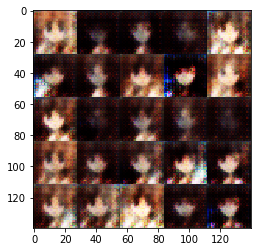

Epoch 3/24... Discriminator Loss: 0.9081... Generator Loss: 1.0512
Epoch 3/24... Discriminator Loss: 1.1700... Generator Loss: 1.2445
Epoch 4/24... Discriminator Loss: 0.7042... Generator Loss: 3.6693
Epoch 4/24... Discriminator Loss: 1.0870... Generator Loss: 0.9048
Epoch 4/24... Discriminator Loss: 1.3811... Generator Loss: 0.4971


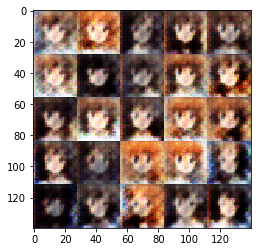

Epoch 4/24... Discriminator Loss: 1.1985... Generator Loss: 1.1936
Epoch 5/24... Discriminator Loss: 1.1482... Generator Loss: 0.7306
Epoch 5/24... Discriminator Loss: 1.2730... Generator Loss: 0.6335
Epoch 5/24... Discriminator Loss: 0.6519... Generator Loss: 1.9467
Epoch 5/24... Discriminator Loss: 0.6792... Generator Loss: 1.7116


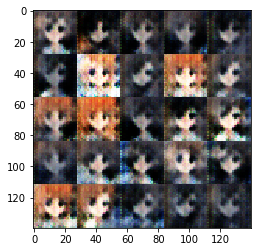

Epoch 6/24... Discriminator Loss: 0.8539... Generator Loss: 1.3727
Epoch 6/24... Discriminator Loss: 1.0735... Generator Loss: 2.6667
Epoch 6/24... Discriminator Loss: 0.9500... Generator Loss: 1.3157
Epoch 6/24... Discriminator Loss: 1.1973... Generator Loss: 0.7116
Epoch 7/24... Discriminator Loss: 1.1126... Generator Loss: 1.5379


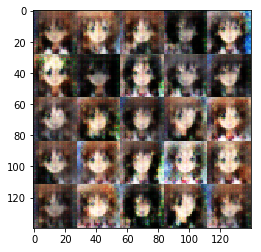

Epoch 7/24... Discriminator Loss: 1.2709... Generator Loss: 0.5956
Epoch 7/24... Discriminator Loss: 1.3720... Generator Loss: 2.6816
Epoch 7/24... Discriminator Loss: 1.4127... Generator Loss: 0.5095
Epoch 8/24... Discriminator Loss: 1.0412... Generator Loss: 0.8156
Epoch 8/24... Discriminator Loss: 1.3938... Generator Loss: 0.5335


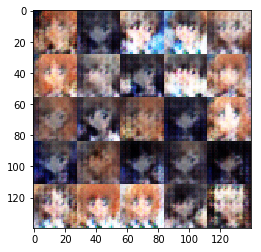

Epoch 8/24... Discriminator Loss: 0.8162... Generator Loss: 1.5279
Epoch 8/24... Discriminator Loss: 1.0525... Generator Loss: 0.8672
Epoch 9/24... Discriminator Loss: 1.1171... Generator Loss: 0.9977
Epoch 9/24... Discriminator Loss: 1.3858... Generator Loss: 0.5276
Epoch 9/24... Discriminator Loss: 2.3365... Generator Loss: 0.2208


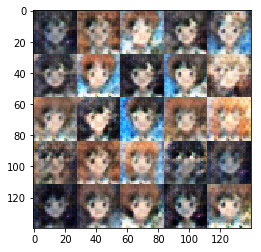

Epoch 9/24... Discriminator Loss: 0.6264... Generator Loss: 2.4615
Epoch 10/24... Discriminator Loss: 1.0745... Generator Loss: 1.1667
Epoch 10/24... Discriminator Loss: 1.0017... Generator Loss: 2.0759
Epoch 10/24... Discriminator Loss: 0.9569... Generator Loss: 1.4288
Epoch 10/24... Discriminator Loss: 1.3956... Generator Loss: 2.9239


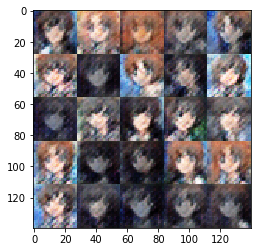

Epoch 10/24... Discriminator Loss: 0.9924... Generator Loss: 1.5815
Epoch 11/24... Discriminator Loss: 0.7198... Generator Loss: 1.4476
Epoch 11/24... Discriminator Loss: 1.1437... Generator Loss: 2.1425
Epoch 11/24... Discriminator Loss: 0.7286... Generator Loss: 1.4594
Epoch 11/24... Discriminator Loss: 0.7999... Generator Loss: 1.6894


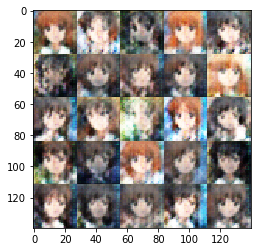

Epoch 12/24... Discriminator Loss: 1.0522... Generator Loss: 1.0429
Epoch 12/24... Discriminator Loss: 1.3825... Generator Loss: 0.5467
Epoch 12/24... Discriminator Loss: 0.9959... Generator Loss: 0.9278
Epoch 12/24... Discriminator Loss: 0.9038... Generator Loss: 1.1366
Epoch 13/24... Discriminator Loss: 0.7056... Generator Loss: 1.4512


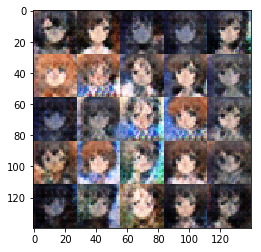

Epoch 13/24... Discriminator Loss: 1.4839... Generator Loss: 0.5020
Epoch 13/24... Discriminator Loss: 0.7528... Generator Loss: 2.0173
Epoch 13/24... Discriminator Loss: 1.0245... Generator Loss: 1.0349
Epoch 14/24... Discriminator Loss: 0.6698... Generator Loss: 1.6130
Epoch 14/24... Discriminator Loss: 0.8142... Generator Loss: 1.2166


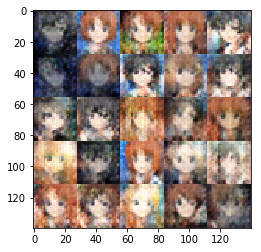

Epoch 14/24... Discriminator Loss: 0.4884... Generator Loss: 2.6223
Epoch 14/24... Discriminator Loss: 0.9293... Generator Loss: 1.0196
Epoch 15/24... Discriminator Loss: 0.6630... Generator Loss: 2.1425
Epoch 15/24... Discriminator Loss: 0.8397... Generator Loss: 1.2373
Epoch 15/24... Discriminator Loss: 1.0060... Generator Loss: 0.8708


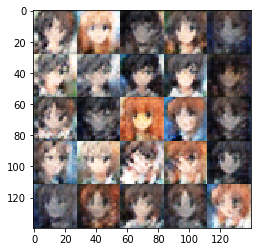

Epoch 15/24... Discriminator Loss: 0.8104... Generator Loss: 1.2789
Epoch 16/24... Discriminator Loss: 0.8530... Generator Loss: 1.5546
Epoch 16/24... Discriminator Loss: 0.6392... Generator Loss: 1.7995
Epoch 16/24... Discriminator Loss: 0.9672... Generator Loss: 2.2753
Epoch 16/24... Discriminator Loss: 1.0300... Generator Loss: 1.2619


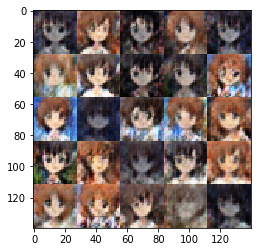

Epoch 17/24... Discriminator Loss: 0.4184... Generator Loss: 3.0160
Epoch 17/24... Discriminator Loss: 0.9149... Generator Loss: 1.5543
Epoch 17/24... Discriminator Loss: 0.9479... Generator Loss: 0.9328
Epoch 17/24... Discriminator Loss: 1.0571... Generator Loss: 0.9044
Epoch 18/24... Discriminator Loss: 0.9572... Generator Loss: 1.0392


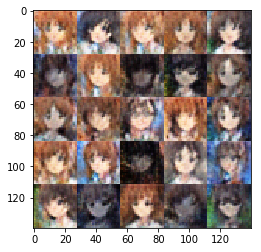

Epoch 18/24... Discriminator Loss: 2.5700... Generator Loss: 4.8259
Epoch 18/24... Discriminator Loss: 0.7760... Generator Loss: 1.2520
Epoch 18/24... Discriminator Loss: 0.8499... Generator Loss: 1.2613
Epoch 19/24... Discriminator Loss: 0.9033... Generator Loss: 1.2667
Epoch 19/24... Discriminator Loss: 1.0146... Generator Loss: 0.9711


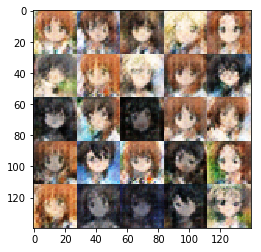

Epoch 19/24... Discriminator Loss: 0.7736... Generator Loss: 1.3070
Epoch 19/24... Discriminator Loss: 0.8168... Generator Loss: 1.6358
Epoch 20/24... Discriminator Loss: 1.7880... Generator Loss: 0.3506
Epoch 20/24... Discriminator Loss: 0.8411... Generator Loss: 1.7782
Epoch 20/24... Discriminator Loss: 0.8979... Generator Loss: 3.0622


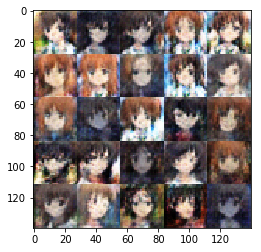

Epoch 20/24... Discriminator Loss: 0.8668... Generator Loss: 1.1537
Epoch 20/24... Discriminator Loss: 0.8058... Generator Loss: 2.2433
Epoch 21/24... Discriminator Loss: 0.8401... Generator Loss: 2.7671
Epoch 21/24... Discriminator Loss: 0.8095... Generator Loss: 1.5520
Epoch 21/24... Discriminator Loss: 0.7077... Generator Loss: 1.4314


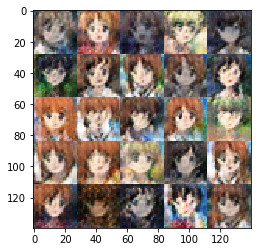

Epoch 21/24... Discriminator Loss: 1.0062... Generator Loss: 1.3962
Epoch 22/24... Discriminator Loss: 0.9035... Generator Loss: 1.1100
Epoch 22/24... Discriminator Loss: 1.8157... Generator Loss: 0.3917
Epoch 22/24... Discriminator Loss: 0.4213... Generator Loss: 3.0201
Epoch 22/24... Discriminator Loss: 0.8048... Generator Loss: 1.3260


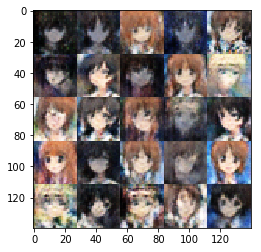

Epoch 23/24... Discriminator Loss: 0.4967... Generator Loss: 2.4619
Epoch 23/24... Discriminator Loss: 1.2687... Generator Loss: 0.6350
Epoch 23/24... Discriminator Loss: 0.5677... Generator Loss: 2.1490
Epoch 23/24... Discriminator Loss: 0.7721... Generator Loss: 1.7572
Epoch 24/24... Discriminator Loss: 0.8725... Generator Loss: 1.1810


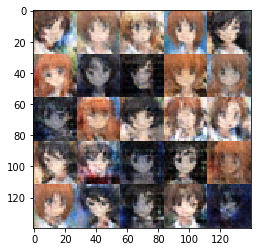

Epoch 24/24... Discriminator Loss: 0.7068... Generator Loss: 1.5718
Epoch 24/24... Discriminator Loss: 1.4467... Generator Loss: 4.3228
Epoch 24/24... Discriminator Loss: 1.4567... Generator Loss: 0.6317


In [11]:
batch_size = 100
z_dim = 100
learning_rate = 0.001
beta1 = 0.5

epochs = 24

celeba_dataset = Dataset(image_files)
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)